<a href="https://colab.research.google.com/github/MELAI-1/MY-PROJECT/blob/main/public_Health/Medical_Diagnosis_with_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build_a_Deep_Learning_based_Medical_Diagnoser
## Medical Diagnosis with LSTM

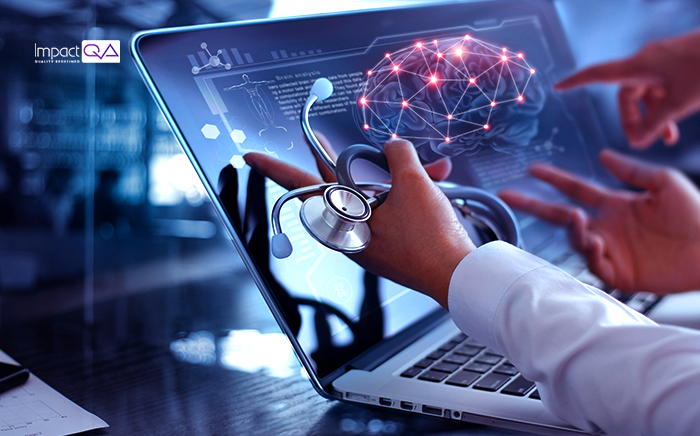

Imagine getting the disease predictions and medication prescriptions in seconds with the help of artificial intelligence (AI). This dream can become a reality with the power of deep learning. Deep learning is a type of artificial intelligence that can learn on its own by analyzing vast amounts of data.

In the field of medicine, Deep Learning can be used to train models to predict diseases and recommend medications based on a patient's symptoms.



Building a deep learning model for medical diagnosis requires a large dataset of labeled medical data. The dataset used in this tutorial includes:

  * Patient Symptoms: Textual descriptions of the patient's symptoms.
  * Diagnoses: The confirmed diseases for each patient.
  * Medications: The prescribed medications for each patient's condition.

# **Step 1: Importing necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# **Step 2: Loading the Data**

In [ ]:
data = pd.read_csv('/content/medical_data.csv')
data.head()

,Patient_Problem,Disease,Prescription
0,"Constant fatigue and muscle weakness, struggli...",Chronic Fatigue Syndrome,"Cognitive behavioral therapy, graded exercise ..."
1,"Frequent severe migraines, sensitivity to ligh...",Migraine with Aura,"Prescription triptans, avoid triggers like bri..."
2,"Sudden weight gain and feeling cold, especiall...",Hypothyroidism,Levothyroxine to regulate thyroid hormone levels.
3,"High fever, sore throat, and swollen lymph nod...",Mononucleosis,"Rest and hydration, ibuprofen for pain."
4,"Excessive thirst and frequent urination, dry m...",Diabetes Mellitus,Insulin therapy and lifestyle changes.


In [ ]:
data.shape

(407, 3)

The dataset contains 407 patients with 3 features including:

  * **Patient problem:** This shows how many seconds have passed since the first transaction in the dataset.
  * **Disease:** These are special features created to hide sensitive information about the original data.
  * **Prescription:** Transaction amount.
  

Now, let's explore if we have nan value in the dataset

In [ ]:
nan_values = data.isnull().sum()
print(nan_values)



Patient_Problem    0
Disease            0
Prescription       0
dtype: int64


# **Step 3: Data Preprocessing and Preparation**

Before using medical data in a deep learning model, it needs to be preprocessed to ensure the model can understand it.

## 1-Tokenizing and Sequencing Text Data

A **tokenizer** variable is created to convert the textual data into sequences of integers. It only considers the top 5,000 words in the dataset in order to reduce the complexity. If the model encounters any out-of-vocabulary words during the training process then it will be replaced with the **'OOV'** token.

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Patient_Problem'])
sequences = tokenizer.texts_to_sequences(data['Patient_Problem'])

## 2-Padding Sequences

In order to make the input sequences have the same length, the code finds the longest sequence and pads all other sequences with zeros at the end (post padding) to match this sentence.

In [ ]:
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

## 3-Encoding the Labels and Converting them to categorical

We will encode the **Disease** and **Prescription** columns as integers. Then the integer-encoded labels are converted into binary class matrices.

### a)-Encoding the labels

In [ ]:
label_encoder_disease = LabelEncoder()
label_encoder_prescription = LabelEncoder()

disease_labels = label_encoder_disease.fit_transform(data['Disease'])
prescription_labels = label_encoder_prescription.fit_transform(data['Prescription'])

### b)-Converting labels to categorical

In [9]:
disease_labels_categorical = to_categorical(disease_labels)
prescription_labels_categorical = to_categorical(prescription_labels)

##4-Combining Labels into a Multi-label Target Variable

Finally, now we will stack the binary class matrices together to form a single multi-label target variable **Y**. This allows the model to predict both **Disease** and **Prescription** from the patient's problem.

In [17]:
Y = np.hstack((disease_labels_categorical, prescription_labels_categorical))

# **Step 4: Model Building**

Now, we will build the model using the LSTM and Sequential algorithm from TensorFlow. This model will learn from our preprocessed dataset to predict diseases based on patient symptoms.

## 1-Defining Model Architecture

In [18]:
input_layer = Input(shape=(max_length,))

embedding = Embedding(input_dim=5000, output_dim=64)(input_layer)
lstm_layer = LSTM(64)(embedding)

disease_output = Dense(len(label_encoder_disease.classes_), activation='softmax',
name='disease_output')(lstm_layer)

prescription_output = Dense(len(label_encoder_prescription.classes_),
activation='softmax', name='prescription_output')(lstm_layer)

## 2-Compiling the model

In [19]:
model = Model(inputs=input_layer, outputs=[disease_output, prescription_output])

model.compile(
    loss={'disease_output': 'categorical_crossentropy',
    'prescription_output': 'categorical_crossentropy'},
    optimizer='adam',
    metrics={'disease_output': ['accuracy'], 'prescription_output': ['accuracy']}
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 17, 64)    │    320,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_output      │ (None, 178)       │     11,570 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prescription_output │ (None, 388)       │     25,220 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 389,814 (1.49 MB)

 Trainable params: 389,814 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

## 3-Training the model

In [20]:
model.fit(padded_sequences, {'disease_output': disease_labels_categorical, 'prescription_output':prescription_labels_categorical}, epochs=100, batch_size=32)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - disease_output_accuracy: 0.0141 - disease_output_loss: 5.1772 - loss: 11.1409 - prescription_output_accuracy: 0.0073 - prescription_output_loss: 5.9638
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - disease_output_accuracy: 0.0324 - disease_output_loss: 5.1574 - loss: 11.1181 - prescription_output_accuracy: 0.0068 - prescription_output_loss: 5.9606
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - disease_output_accuracy: 0.0271 - disease_output_loss: 5.0991 - loss: 11.0634 - prescription_output_accuracy: 0.0098 - prescription_output_loss: 5.9642
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - disease_output_accuracy: 0.0342 - disease_output_loss: 4.9694 - loss: 10.9339 - prescription_output_accuracy: 0.0109 - prescription_output_loss: 5.9646
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - disease_output_accuracy: 0.0323 - disease_output_loss: 4.8925 - loss: 10.8391 - prescription_output_accuracy: 0.0227 - pre

# **Step 5: Making Predictions**

The model is used to make predictions for new patients:

   1. Pre-processed the patient's symptoms by performing tokenization and
padding.
   2. Feed the pre-processed data into the trained model.
   3. The model predicts the disease and medication based on the patient's symptoms.
   4. The predicted disease and medication will be presented.

In [22]:
def make_prediction(patient_problem):
    # Preprocessing the input
    sequence = tokenizer.texts_to_sequences([patient_problem])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Making prediction
    prediction = model.predict(padded_sequence)

    # Decoding the prediction
    disease_index = np.argmax(prediction[0], axis=1)[0]
    prescription_index = np.argmax(prediction[1], axis=1)[0]

    disease_predicted = label_encoder_disease.inverse_transform([disease_index])[0]
    prescription_predicted = label_encoder_prescription.inverse_transform([prescription_index])[0]

    print(f"Predicted Disease: {disease_predicted}")
    print(f"Suggested Prescription: {prescription_predicted}")



In [23]:
patient_input = "I've experienced a loss of appetite and don't enjoy food anymore."
make_prediction(patient_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted Disease: Depression
Suggested Prescription: Antidepressants; eating nutrient-rich foods.
